# Energy Production Model Cross Validation

### 1. Introduction

In this project, we will build 2 models to predict the energy production of a Combined Cycle Power Plant. We will then cross validate the models to choose the model that most accurately predicts the production.

The data was collected over a 6 year period (2006-2011) and contains 9568 data points. We will be analyzing 4 independant variables to predict one dependant variable.

__Independant Variables:__

- __Ambient Temperature (T)__  _Numeric/Continuous_ - Average hourly temperature in the area surrounding the power plant. Range: 1.81&deg;C - 37.11&deg;C

- __Ambient Pressure (AP)__ _Numeric/Continuous_ - Average hourly air pressure in the area surrounding the power plant. Range: 992.89 - 1033.30 milibar

- __Relative Humidity (RH)__ _Numeric/Continuous_ - Average hourly humidity surrounding the plant relative to the max humidity at the current temperature. Range: 25.56% - 100.16%

- __Exhaust Vacuum (V)__ _Numeric/Continuous_ - Average hourly output from the plant's exhaust vacuum. Range: 25.36 - 81.56 cm Hg

__Dependant Variable:__

- __Electrical Energy Output__ _Numeric/Continuous_ - Net hourly energy output from the plant. Range: 420.26 - 495.76 MW

[Data Source](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant#)

This notebook contains the following steps:

1. [Introduction](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=8aeFqHctuHsX&line=25&uniqifier=1)
2. [Load Data](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=Bfz3m8ty3guo&line=4&uniqifier=1) into DataFrame
3. [Exploratory Data Analysis](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=sf1Lwoiu4VB-&line=4&uniqifier=1)
4. [Model Creation and Evaluation](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=t4b1FmdH3UpK&line=1&uniqifier=1)
5. [Conclusion](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=wM6dVlGI35E1&line=16&uniqifier=1)


In [33]:
# Importing required libraries.

import pandas as pd
import numpy as np

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 2. Load Data

- Read data from raw github file into our pandas DataFrame
- Show snapshot of the data using `.head()` and `.tail()`

In [34]:
url = 'https://raw.githubusercontent.com/thesabermaniac/EnergyProduction/main/Day1_Data.csv'
plant_data = pd.read_csv(url)

# create a copy in case we mess up our original
plant_data_copy = plant_data.copy()

plant_data.head()

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [35]:
plant_data.tail()

,T,V,AP,RH,EP
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74
9567,21.60,62.52,1017.23,67.87,453.28


### 3. Exploratory Data Analysis

- [Clean data](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=0CgVmU3d62ZW)
- [Describe data](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=HSXF63z64xDY)
- [Detect and remove outliers](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=Fa2x49RYqQxG)
- [Check distribution](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=GtlSsUC7UWQ6)
- [Analyze relationship between variables](https://colab.research.google.com/drive/1yJUlAcGszICBVJhzEdy32CGE6yImZH7K#scrollTo=9GHEkhqNnUhB)


#### Clean data

Make sure the data is usable by removing or fixing any false/missing data and making it more readable



__Rename columns__

Rename the columns to make the data more readable

In [36]:
# rename columns. Set inplace to True so it directly changes the current DataFrame
plant_data.rename(columns={'T': 'Temperature', 
                           'V': 'ExhaustVacuum', 
                           'AP': 'AmbientPressure', 
                           'RH': 'RelativeHumidity',
                           'EP': 'EnergyProduction'}, 
                  inplace=True)
plant_data.head()

,Temperature,ExhaustVacuum,AmbientPressure,RelativeHumidity,EnergyProduction
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


__Check for null values__

Make sure there is no data missing from our dataset

In [37]:
# check for null values
print(plant_data.isnull().sum())

Temperature         0
ExhaustVacuum       0
AmbientPressure     0
RelativeHumidity    0
EnergyProduction    0
dtype: int64


As you can see, there are no null values, which tells us there is likely no missing data

__Check data types__

Make sure the data is stored in a way we can use it (i.e. numbers are stored as numbers)

In [38]:
plant_data.dtypes

Temperature         float64
ExhaustVacuum       float64
AmbientPressure     float64
RelativeHumidity    float64
EnergyProduction    float64
dtype: object

It looks like everything is stored properly. All our variables are stored as floating point numbers.

__Check unique values__

Check how many unique values each variable has. This gives us a better idea of the variance in our data

In [39]:
plant_data.nunique(axis=0)

Temperature         2773
ExhaustVacuum        634
AmbientPressure     2517
RelativeHumidity    4546
EnergyProduction    4836
dtype: int64

#### Describe data

Get an idea of the size and type of the dataset



In [40]:
# Get the size of the dataset
plant_data.shape

(9568, 5)

`plant_data.shape` returned (9568, 5) which tells me that this dataset contains 9568 rows and 5 columns. This is exactly what we were expenting since there are 5 variables (4 independant, 1 dependant) and 9568 data points, as mentioned in the introduction.

In [41]:
# Statistical summary of Numeric variables
plant_data.describe()

,Temperature,ExhaustVacuum,AmbientPressure,RelativeHumidity,EnergyProduction
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


#### Detecting and removing Outliers

Remove outliers so we can have a more accurate picture of the data we're dealing with.

__Use box plots to find outliers__

We will now use box plot visualizations for each of the variables to discover any outliers. The outliers will be plotted as dots outside the lines of the box plot.

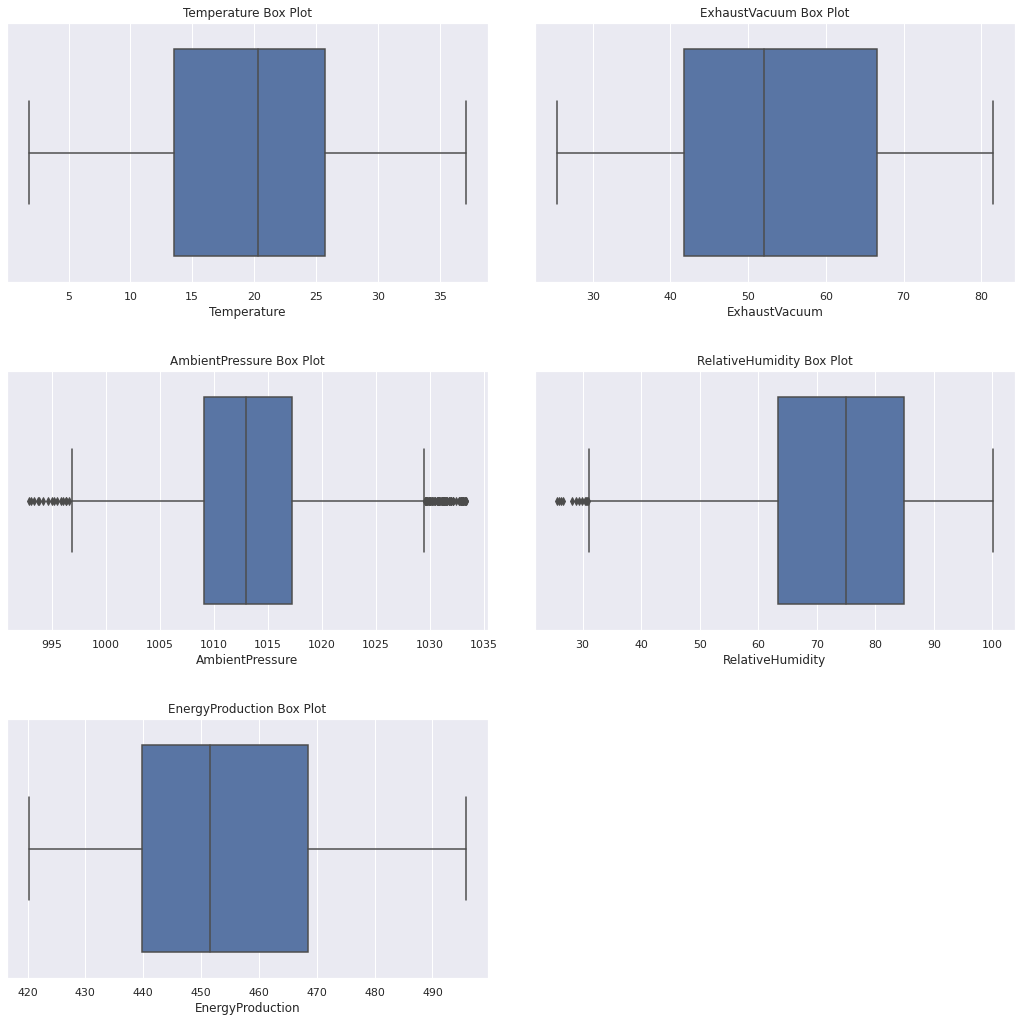

In [67]:
plt.figure(figsize=(15,15))

# Display box plot for each variable
sub_plot = 321
for col in plant_data.columns:
  plt.subplot(sub_plot)
  sns.boxplot(x=plant_data[col])
  plt.title(col + " Box Plot")
  sub_plot = sub_plot + 1

plt.tight_layout(pad=3.0)
plt.show()

As you can see, ambient pressure and relative humidity have a number of outliers while the other variables seem to be fine.

__Remove outliers using IQR__

We will now remove the rows containing outliers using a technique called the IQR score, or interquartile range score.

Essentially, what this does is it breaks the each column into 4 quarters of data, much like the boxplot. The IQR represents the dispersion of the middle 50% of the data, or the difference between the 75th and 25th percentiles. 

$$IQR = Q3 - Q1$$

We then use that IQR to find any outliers by finding any data points that are lower than $Q1 - 1.5 * IQR$ or greater than $Q3 + 1.5 * IQR$. In other words, we're finding any data points that are far enough from the edges of the data to be considered an outlier (in this case $\pm 1.5 * IQR$).

Lastly, we create a trimmed data frame that doesn't include any outliers.

In [43]:
# defining IQR for each column
Q1 = plant_data.quantile(0.25)
Q3 = plant_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Temperature         12.2100
ExhaustVacuum       24.8000
AmbientPressure      8.1600
RelativeHumidity    21.5025
EnergyProduction    28.6800
dtype: float64


In [44]:
# creating trimmed data frame
trimmed_data = plant_data[~((plant_data < (Q1 - 1.5 * IQR)) | (plant_data > (Q3 + 1.5 * IQR))).any(axis=1)]
trimmed_data.shape

(9468, 5)

As you can see, we've trimmed exactly 100 rows of outliers from our dataset (from 9568 rows to 9468).

Now, let's see how it's effected our other metrics.

In [45]:
trimmed_data.describe()

,Temperature,ExhaustVacuum,AmbientPressure,RelativeHumidity,EnergyProduction
count,9468.000000,9468.00000,9468.000000,9468.000000,9468.000000
mean,19.719883,54.41369,1013.148802,73.322083,454.209298
std,7.427311,12.70141,5.704623,14.551203,17.029285
min,1.810000,25.36000,996.870000,31.150000,420.260000
25%,13.577500,41.74000,1009.090000,63.285000,439.697500
50%,20.500000,52.72000,1012.900000,74.980000,451.210000
75%,25.760000,66.54000,1017.170000,84.840000,468.190000
max,37.110000,81.56000,1029.410000,100.160000,495.760000


Here are the meaningful changes in our data:

__Ambient Pressure:__

min: 992.89 -> 996.87
<br>max: 1033.3 -> 1029.41

__Relative Humidity:__

min: 25.56 -> 31.15


As indicated in our box plots, the only columns that had outliers that were removed were Ambient Pressure and Relative Humidity. Ambient Pressure had outliers on both sides of its data, as its min increased and max decreased. Relative Humidity only had outliers on the low end of its data as it saw an increase in its min, but no decrease in its max.

The removal of the outliers also led to some minor changes in mean, std, and the quartile values, but those are largely inconsequential.

#### Checking Distribution

Now, we're going to check the distribution of the data. We will make histograms of each variable using seaborn's `.histplot()` method.

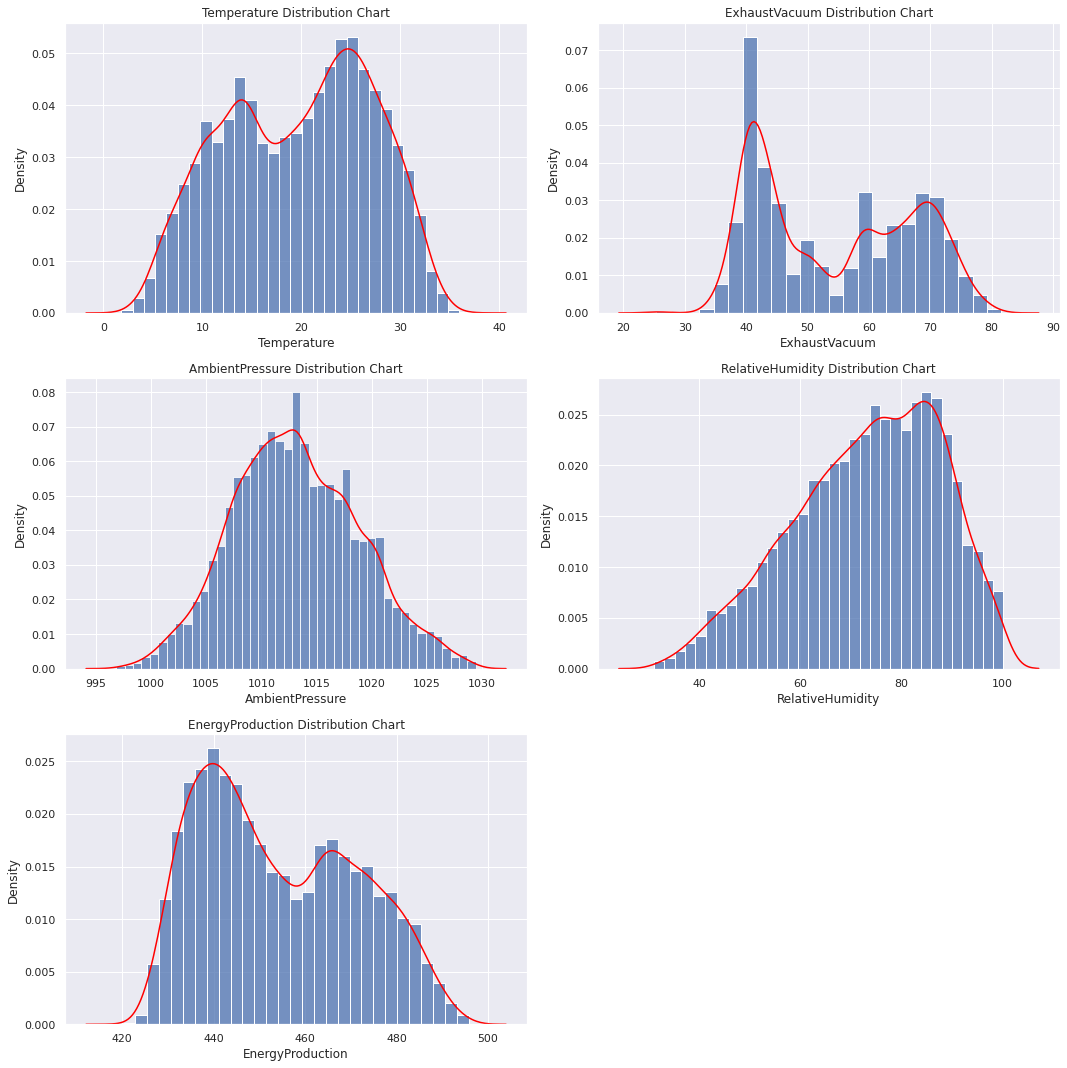

In [89]:
# set grid size
figure, axes = plt.subplots(3, 2, figsize=(15,15))

# create histogram for each column
x = 0
y = 0
for column in trimmed_data.columns:
  sns.histplot(trimmed_data[column], ax=axes[x, y], stat='density')
  sns.kdeplot(trimmed_data[column], ax=axes[x, y], color='red', alpha=0.5)
  axes[x, y].set_title(column + " Distribution Chart")
  x = x + 1 if y == 1 else x
  y = y + 1 if y == 0 else 0

# discard extra subplot
axes[2,1].set_axis_off()

# set spacing
figure.tight_layout()

plt.show()

__Takeaways:__

1. AmbientPressure has a normal distribution
2. RelativeHumidity has a left-skewed normal distribution
3. Temperature, ExhaustVaccum, and EnergyProduction all have Bimodal distributions

Since EnergyProduciton has a Bimodal distribution, it's likely that Temperatue and ExhaustVacuum will be good predictors because they also have Bimodal distributions.

#### Analyzing correlation between variables

Next, we're going to analyze the correlation between our variables. This will tell us how related two variables are to each other. If variable _b_ is usually high when variable _a_ is high and vice versa (_b_ is low when _a_ is low), there's a strong positive correlation. Alternatively, if variable _b_ is high when variable _a_ is low and vice versa (_b_ is low when _a_ is high), there's a strong negative correlation.

We're going to use the Pandas `.corr()` function to get our correlation matrix, and Seaborn's `.heatmap()` function to visualize it.

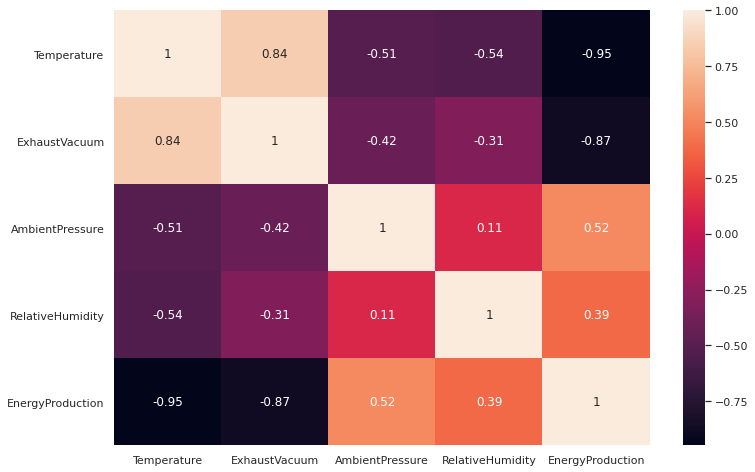

In [86]:
# set correlation matrix
corr_matrix = trimmed_data.corr()

# show heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

__Takeaways:__

1. Temperature and Exhaust Vacuum both have a very strong negative correlation with EnergyProduction. The higher the temperature or exhaust vacuum, the lower the energy output will be, and vice versa.
2. Temperature and ExhaustVacuum have a strong collinear relationship (they correlate strongly with each other). If one is high, the other is likely to also be high, and vice versa. It's likely that including both variables in our model would be redundant.
3. Ambient pressure has a modest positive correlation with our dependant variable EnergyProduction. It's likely that the energy production will rise as ambient pressure rises, and vice versa.
4. RelativeHumidity has a low positive correlation with EnergyProduction.

Now, we're going to use Seaborn's `.regplot()` method to plot the relationships between our independant variables and our dependant variable.

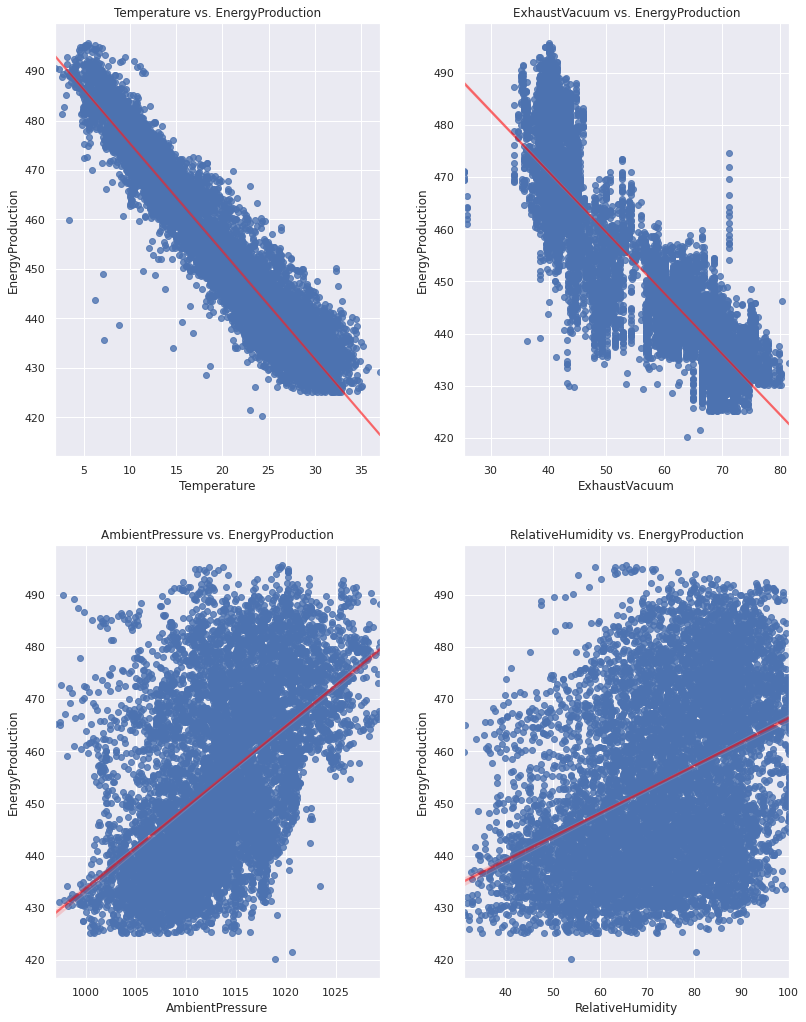

In [88]:
plt.figure(figsize=(12,15))

sub = 221
for column in trimmed_data.columns:
  if column != "EnergyProduction":
    plt.subplot(sub)
    sns.regplot(data=trimmed_data, x=column, y="EnergyProduction", line_kws = {'color': 'red', 'alpha': 0.5})
    plt.title(column + " vs. EnergyProduction")
    sub = sub + 1

plt.tight_layout(pad=3.0)
plt.show()

__Takeaways:__

1. Like we saw in the correlation matrix, Temperature and ExhaustVacuum both have very strong negative correlations with EnergyProduction.
2. It looks like ExhaustVacuum has more outliers than Temperature so Temperature will probably be a slightly better predictor.
3. AmbientPressure has a solid positive correlation, but is more spread out than Temperature and ExhaustVacuum.
4. RelativeHumidity has a weak positive correlation, as seen in the correlation matrix. It's not likely that this variabel will add anything if we add it to our model

### 4. Model Creation and Evaluation

Now, it's time to combine everything we learned in our EDA and apply it to a linear regression model. 

As we saw in our correlation analysis, Temperature and ExhaustVacuum are highly collinear. Therefore, we're only going to be using one of those variables in our model.

We also learned that RelativeHumidity had a low correlation to ProductionOutput. Therefore, we will be leaving that variable out completely.




#### __First Model__

Based on our analysis, it appears that Temperature had slighlty less variance than ExhaustVacuum, so our first model is going to leave out ExhaustVacuum and use Temperature and AmbientPressure to try to predict EnergyProduction.

---
__Split training and testing data__

The first step is to split our data into training and testing data. We're going to split our data into a 70/30 split using SciKitLearn's `train_test_split` function. In other words, we're setting aside 30% of the data for testing and leaving 70% for training.

In [49]:
# Make a copy of the dataset
model_data = trimmed_data.copy()

# Isolate the x and y variables. 
# x will be the independant variables (everything except EnergyProduction)
x = model_data.loc[:, model_data.columns != 'EnergyProduction']
# y will be the dependant variable (EnergyProduction)
y = model_data.loc[:, model_data.columns == 'EnergyProduction']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12)

__Isolate training data__

Next, we contcatonate the x and y's of the training data to make a new data frame containing our training data.

In [50]:
# Create training_data data frame
training_data = pd.concat([x_train, y_train], axis=1)

# check result is as expected
print("The number of observations in the training_data dataframe: {}".format(training_data.shape[0]))
print("The first few rows of the training_data dataframe:")
training_data.head()

The number of observations in the training_data dataframe: 6627
The first few rows of the training_data dataframe:


,Temperature,ExhaustVacuum,AmbientPressure,RelativeHumidity,EnergyProduction
2694,7.28,40.67,1020.16,72.70,493.30
7781,31.85,68.30,1014.76,47.06,428.72
8991,8.68,39.61,1021.54,77.98,486.31
5064,3.91,35.47,1016.92,86.03,488.67
4824,21.18,45.01,1012.57,48.05,451.62


You can tell this is a random sampling of the data as the row numbers aren't in any particular order

__Build first model__

Lastly, we use `statsmodel.formula.api` to build our model using our chosen predictors (Temperature and AmbientPressure)

In [51]:
# Build ols model
model1 = smf.ols('EnergyProduction ~ Temperature + AmbientPressure', data = training_data).fit()

# Display model statistics
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:       EnergyProduction   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 3.056e+04
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:17:11   Log-Likelihood:                -20484.
No. Observations:                6627   AIC:                         4.097e+04
Df Residuals:                    6624   BIC:                         4.099e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         338.3252     13.498     

__Takeaways:__

1. This model has a $R^2$ of .902 which is very good. 
2. All the model coefficients have a P_value of less than 0.05, indicating that they're all statistically significant

This model is looking very good. However, we can't be confident in the accuracy of that scores given the randomness of the data selection for the test/train split.

To solve this, we will perform a k-fold cross validation of our model, using SciKitLearn's `cross_val_score` tools. 

__K-fold cross validation__

We will now perform a k-fold cross validation on our model. This tests how our model performs when presented with new data. It takes our dataset and splits it into _k_ random groups. For each group, we set aside that group as test data and fit our model using the remaining groups as our training data. We then evaluate the accuracy of our model based on that test/train split. We repeat this process for every group and output the mean score.

__Example:__

Imagine we're performing a cross validation with 5 folds. We'll split the data into 5 random groups of equal size. We then set aside group 1 to be our test data and fit our model using the remaining 4 groups. This is how our groups of data will look in our first model:

|1|2|3|4|5|
|----|-----|-----|-----|-----|
|_TEST_|train|train|train|train|

We then calculate the $R^2$ of our model using the first group as our test data. 

Next, we make a new model using groups 1, 3, 4, and 5 as our training data and group 2 as our test data. Our second model will look like this:

|1|2|3|4|5|
|----|-----|-----|-----|-----|
|train|_TEST_|train|train|train|

Again, we test the accuracy of our model based on this new split and store our $R^2$ score.

We repeat this process 3 more times, at which point our split will look like this:

|1|2|3|4|5|
|----|-----|-----|-----|-----|
|train|train|train|train|_TEST_|

Finally, we take the arithmetic mean of all 5 of our $R^2$ scores which gives us a more accurate estimate of how accurate our model is.



In [90]:
# fit the model using 5-fold cross validation
model_1_scores = cross_val_score(LinearRegression(), x_train[['Temperature', 'AmbientPressure']], y_train, cv=5)

# print list of scores
print("Here are the R^2 values for each of our models:")
print(model_1_scores)
# print the mean value of the 5 models
print("Here is the mean of those 5 scores:")
np.mean(model_1_scores)

Here are the R^2 values for each of our models:
[0.90582696 0.9044129  0.90113923 0.90292985 0.89536914]
Here is the mean of those 5 scores:


0.901935616244512

As we can see, we get a very similar score to our original $R^2$ when we run a 5-fold cross validation (90.2%)

__RMSE Assessment__

We will now assess our model using RMSE, or root mean square error. This helps us understand the variance of our residual data as it tells us the average squared error of our model's prediction. In other words, it tells us how far off the average prediction is from its actual value.

A good RMSE score depends on the range of your dependant variable. For example, if you're trying to predict a value with a range of 50 - 1,200, a RMSE of 3 would be very good. That would tell you that your average prediction is off by 3 units, which is excellent when you're dealing with data that has a rang of 1,150. However, if you're dependant variable's range is 9 - 15, 3 would be a horrible RMSE since you're dealing with a range of 6, so your average prediction is off by 50% of the range.

Like the $R^2$ assessment above, we're going to use a k-fold cross validation here to ensure accuracy.

In [91]:
model_1_rmse_scores = cross_val_score(LinearRegression(), 
                                       x_train[['Temperature', 'AmbientPressure']], 
                                        y_train, scoring="neg_mean_squared_error",cv=5) 
rmse_scores_1 = np.sqrt(-model_1_rmse_scores)

print("Here are the RMSE scores for each of our models:")
print(rmse_scores_1)
print("Here's the mean of those 5 scores:")
print(rmse_scores_1.mean())

Here are the RMSE scores for each of our models:
[5.22626668 5.3408195  5.27686259 5.41958864 5.36284949]
Here's the mean of those 5 scores:
5.325277379625332


Our k-fold cross validarion produces a RMSE of 5.33. This is acceptable in our case given a range of 420.26 - 495.76MW of Energy Production. This means our average prediction is off by 5.33 or 7.1% of our range ($5.33/(495.76-420.26)*100$).

#### __Second Model__

We will now build a second model with our other collinear independant variable, ExhaustVacuum instead of Temperature. We will still use AmbientPressure as our second predictor.

We will then compare the efficacy of our two models to determine the better model.

__Build model and display summary stats__

We'll start by building our model with our chosen variables. We'll then output the model's summary statistics to guage our model's performance.

In [54]:
# Create second model with ExhaustVacuum and AmbientPressure
model2 = smf.ols('EnergyProduction ~ ExhaustVacuum + AmbientPressure', data = training_data).fit()

# Output summary stats
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       EnergyProduction   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 1.210e+04
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:17:12   Log-Likelihood:                -23093.
No. Observations:                6627   AIC:                         4.619e+04
Df Residuals:                    6624   BIC:                         4.621e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -66.0993     19.011     

__Takeaways:__

1. The $R^2$ of our second model (0.785) is significantly lower than the first one (0.902). We'll perform a k-fold cross validation to make sure this holds true over multiple iterations.
2. The p-values are all below 0.05 which again indicates that all our variables are statistically significant.



__K-fold cross validation__

Let's verify these findings by performing a k-fold cross validation.

In [92]:
# Get k-fold scores
model_2_scores = cross_val_score(LinearRegression(), x_train[['ExhaustVacuum', 'AmbientPressure']], y_train, cv=5)

# Display k-fold results
# print list of scores
print("Here are the R^2 values for each of our models:")
print(model_2_scores)
# print the mean value of the 5 models
print("Here is the mean of those 5 scores:")
np.mean(model_2_scores)

Here are the R^2 values for each of our models:
[0.77444408 0.78819441 0.78654572 0.78394335 0.79053702]
Here is the mean of those 5 scores:


0.784732915573885

As you can see, our original $R^2$ is confirmed by our k-fold cross validation, which produces a mean of 0.785

__RMSE Assessment__

Now, we'll calculate the RMSE of our model using a k-fold cross validation.

In [56]:
model_2_rmse_scores = cross_val_score(LinearRegression(), 
                                       x_train[['ExhaustVacuum', 'AmbientPressure']], 
                                        y_train, scoring="neg_mean_squared_error",cv=5) 
rmse_scores_2 = np.sqrt(-model_2_rmse_scores)

print("Here are the RMSE scores for each of our models:")
print(rmse_scores_2)
print("Here's the mean of those 5 scores:")
print(rmse_scores_2.mean())

Here are the RMSE scores for each of our models:
[8.08826512 7.95017993 7.7538292  8.0855079  7.58786074]
Here's the mean of those 5 scores:
7.893128579684548


This RMSE of 7.89 is significantly worse than the results we got in our first model (5.33). The first model had an RMSE that was 7.1% of the range of our dependant variable. This model's RMSE is 9.4% of the range of EnergyProduction, making it significantly less acurate.

### 5. Conclusion

We started this exersize by trying to find the best model to predict the energy production of a Combined Cycle Power Plant. We were given the Temperature, Ambient Pressure, Exhaust Vacuum, and Relative Humidity of the plant, and we wanted to determine the best combination of variables to use in our model to predict the Energy Production.

Here's what we learned from our analysis:

- We concluded from our EDA that Relative Humidity had little correlation with Energy Production, so we left that out of both our models.
- We also concluded from our EDA that Temperature and Exhaust Vacuum were highly collinear so it would be redundant to use both variables in a model.
- Thus, we built our first model with Temperature and Ambient Pressure and our second model with Exhaust Vacuum and Ambient Pressure. 
- Both models showed statistically significant variables with p-values lower than 0.05
- Model 1 showed impressive accuracy scores with a $R^2$ of 90.2% compared to  78.5% in Model 2.
- Model 1 had RMSE of 5.33, significantly lower than Model 2's 7.89 RMSE.

__Conclusion__

It looks like Model 1, which uses Temperature and Ambient Pressure, is the more accurate predictor of Energy Production as it has a higher $R^2$ and a lower RMSE than Model 2.